In [46]:
# --- Config ---
COMFY = "http://192.168.27.12:8188"   # your ComfyUI server (headless or GUI)
COMFY = "http://127.0.0.1:8188/"
WORKFLOW_JSON = "workflow_12.json"  # your uploaded graph
OUTPUT_DIR = "results"            # local folder to save downloads

# --- Imports ---S
import os, io, json, time, uuid, pathlib, requests
from PIL import Image

os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- helper: compute target size and (optionally) resize before upload ---
from PIL import Image
import os, io, pathlib

MAX_SIDE = 512  # cap while preserving aspect ratio

def prepare_image_for_upload(local_path, *, max_side=MAX_SIDE, out_dir=OUTPUT_DIR):
    """
    Opens local_path, resizes if needed so that max(width, height) <= max_side (AR preserved),
    saves a PNG next to OUTPUT_DIR (to keep things tidy), and returns:
      (path_to_png, target_width, target_height)
    """
    img = Image.open(local_path).convert("RGB")
    w, h = img.size
    scale = 1.0
    if max(w, h) > max_side:
        scale = max_side / float(max(w, h))
    target_w = max(1, int(round(w * scale)))
    target_h = max(1, int(round(h * scale)))
    if scale != 1.0:
        img = img.resize((target_w, target_h), Image.LANCZOS)

    # Save a temp PNG we’ll upload to ComfyUI
    base = pathlib.Path(local_path).stem
    resized_path = os.path.join(out_dir, f"{base}_rsz_{target_w}x{target_h}.png")
    img.save(resized_path, format="PNG")
    return resized_path, target_w, target_h

def prepare_image_for_upload(local_path, *, out_dir=OUTPUT_DIR):
    """
    Opens local_path, keeps full resolution (no resize),
    saves a PNG next to OUTPUT_DIR (to keep things tidy), and returns:
      (path_to_png, width, height)
    """
    img = Image.open(local_path).convert("RGB")
    w, h = img.size

    base = pathlib.Path(local_path).stem
    out_path = os.path.join(out_dir, f"{base}_orig_{w}x{h}.png")
    img.save(out_path, format="PNG")
    return out_path, w, h



# --- API Helpers ---

def upload_image_to_comfy(local_path, server=COMFY, *, dest_name=None, folder_type="input", subfolder="", overwrite=True):
    """
    POST /upload/image
    - folder_type: 'input' places image where LoadImage expects it.
    Returns the filename you should reference in the LoadImage node.
    """
    if dest_name is None:
        dest_name = pathlib.Path(local_path).name

    with open(local_path, "rb") as f:
        files = {"image": (dest_name, f, "image/png")}
        data = {"type": folder_type, "subfolder": subfolder, "overwrite": "true" if overwrite else "false"}
        r = requests.post(f"{server}/upload/image", files=files, data=data, timeout=120)
        r.raise_for_status()
    return dest_name  # ComfyUI references just the basename in LoadImage

def patch_prompt_text(prompt_dict, new_text):
    """
    Updates the first text-encoding node we find with the new prompt.
    Looks for keys like 'text' or 'prompt' in node inputs.
    """
    for node_id, node in prompt_dict.items():
        inputs = node.get("inputs", {})
        if "text" in inputs:
            inputs["text"] = new_text
            return True
        if "prompt" in inputs:
            inputs["prompt"] = new_text
            return True
    return False


def queue_prompt(prompt_dict, server=COMFY, client_id=None):
    """
    POST /prompt
    Returns prompt_id for polling /history/{prompt_id}.
    """
    if client_id is None:
        client_id = str(uuid.uuid4())
    r = requests.post(f"{server}/prompt", json={"prompt": prompt_dict, "client_id": client_id}, timeout=120)
    r.raise_for_status()
    return r.json().get("prompt_id", client_id)

def get_history(prompt_id, server=COMFY):
    """GET /history/{prompt_id} → JSON with outputs and image filenames."""
    r = requests.get(f"{server}/history/{prompt_id}", timeout=120)
    r.raise_for_status()
    return r.json()

def download_image(filename, server=COMFY, *, folder_type="output", subfolder="", to_path=None):
    """
    GET /view?filename=...&subfolder=...&type=output
    Returns local filepath saved under OUTPUT_DIR (default).
    """
    params = {"filename": filename, "subfolder": subfolder, "type": folder_type}
    r = requests.get(f"{server}/view", params=params, timeout=120)
    r.raise_for_status()
    if to_path is None:
        to_path = os.path.join(OUTPUT_DIR, filename)
    with open(to_path, "wb") as f:
        f.write(r.content)
    return to_path

def patch_loadimage_node(prompt_dict, new_filename):
    """
    Updates the first LoadImage-like node we find.
    ComfyUI 'LoadImage' nodes usually expose inputs.image (basename in /input).
    """
    for node_id, node in prompt_dict.items():
        ct = node.get("class_type", "")
        if ct.lower().replace(" ", "") in {"loadimage","imageloader"}:
            # Common schema: {"class_type": "LoadImage", "inputs": {"image": "some.png"}}
            node.setdefault("inputs", {})["image"] = new_filename
            return True
    return False

def patch_simple_knobs_(prompt_dict, *, seed=None, steps=None, cfg=None, width=None, height=None):
    """
    OPTIONAL: if you know your node ids, you can set them here.
    This tries to find likely KSampler/FluxGuidance/Scheduler nodes heuristically.
    Only patches when it finds a matching input field.
    """
    for node in prompt_dict.values():
        inputs = node.get("inputs", {})
        name = node.get("class_type", "").lower()
        if seed is not None and "seed" in inputs:
            inputs["seed"] = int(seed)
        if steps is not None and ("steps" in inputs or "num_inference_steps" in inputs):
            if "steps" in inputs:
                inputs["steps"] = int(steps)
            if "num_inference_steps" in inputs:
                inputs["num_inference_steps"] = int(steps)
        if cfg is not None:
            # Flux guidance scale is often 'guidance' or 'cfg' in custom nodes
            for k in ("guidance", "cfg", "guidance_scale"):
                if k in inputs:
                    inputs[k] = float(cfg)
        if width is not None and "width" in inputs:
            inputs["width"] = int(width)
        if height is not None and "height" in inputs:
            inputs["height"] = int(height)

def patch_simple_knobs(prompt_dict, *,
                       seed=None, steps=None,
                       cfg=None,              # KSampler CFG
                       flux_guidance=None,    # FluxGuidance guidance
                       width=None, height=None):
    """
    Patch common sampler/flux knobs separately.
    """
    for node in prompt_dict.values():
        inputs = node.get("inputs", {})
        ct = node.get("class_type", "").lower()

        # seed and steps
        if seed is not None and "seed" in inputs:
            inputs["seed"] = int(seed)
        if steps is not None and ("steps" in inputs or "num_inference_steps" in inputs):
            if "steps" in inputs:
                inputs["steps"] = int(steps)
            if "num_inference_steps" in inputs:
                inputs["num_inference_steps"] = int(steps)

        # KSampler cfg
        if cfg is not None and "ksampler" in ct and "cfg" in inputs:
            inputs["cfg"] = float(cfg)

        # FluxGuidance guidance
        if flux_guidance is not None and "fluxguidance" in ct and "guidance" in inputs:
            inputs["guidance"] = float(flux_guidance)

        # resolution
        if width is not None and "width" in inputs:
            inputs["width"] = int(width)
        if height is not None and "height" in inputs:
            inputs["height"] = int(height)


# --- Main: run workflow with a dynamic image ---
#seed=2791063517
def run_workflow_with_image(image_path,
                            prompt_json_path=WORKFLOW_JSON,
                            *,
                            seed=2^24, steps=10, cfg=1, flux_guidance=2.5, prompt_text=None, width=512, height=512,
                            comfy_server=COMFY):

    # 0) Prepare the image (resize if needed; get final W/H)
    prepped_path, target_w, target_h = prepare_image_for_upload(image_path)
    # 1) Upload the image so LoadImage can find it under 'input'
    uploaded_name = upload_image_to_comfy(prepped_path, server=comfy_server)

    # 2) Load your saved ComfyUI workflow JSON
    with open(prompt_json_path, "r") as f:
        prompt = json.load(f)

    # 3) Patch the LoadImage node to the new filename (and optional knobs)
    ok = patch_loadimage_node(prompt, uploaded_name)
    if not ok:
        raise RuntimeError("Could not find a LoadImage node to patch; check your graph JSON.")
    #patch_prompt_text(prompt, "Leave characters intact. Colorize this old photo with deep, vivid natural colors for clothes and background, use 1980s style fashion. Use soft natural skin tones and background colors. Inconsistent colors, bleeding, rusting, and blending is STRICTLY PROHIBITED.")
    patch_prompt_text(prompt, prompt_text)
    #patch_simple_knobs(prompt, seed=seed, steps=steps, cfg=cfg, width=target_w, height=target_h)
    patch_simple_knobs(
        prompt,
        seed=seed,
        steps=steps,
        cfg=cfg,                   # value for KSampler CFG
        flux_guidance=flux_guidance,         # set your FluxGuidance here
        width=target_w,
        height=target_h
    )

    # 4) Queue the prompt and poll history until it finishes
    prompt_id = queue_prompt(prompt, server=comfy_server)
    # Basic polling loop — you can also use websockets for live updates
    deadline = time.time() + 600  # 10 min max
    output_files = []
    while time.time() < deadline:
        hist = get_history(prompt_id, server=comfy_server)
        # History payload nests outputs under the prompt_id
        item = hist.get(prompt_id)
        if item and "outputs" in item:
            # Collect all image outputs from any node that produced images
            for node_id, node_out in item["outputs"].items():
                images = node_out.get("images", [])
                for im in images:
                    fn = im.get("filename")
                    sub = im.get("subfolder", "")
                    typ = im.get("type", "output")
                    if fn:
                        local_path = download_image(fn, server=comfy_server, subfolder=sub, folder_type=typ)
                        if local_path not in output_files:
                            output_files.append(local_path)
            # If we have at least one image, consider it done
            if output_files:
                break
        time.sleep(0.5)

    if not output_files:
        raise RuntimeError("No images returned. Check the server logs and that your SaveImage path is valid.")

    return output_files


def process_folder(input_folder, output_folder,
                   prompt_json_path=WORKFLOW_JSON,
                   *,
                   seed=2791063517, steps=10,
                   cfg=1.0, flux_guidance=2.5,
                   comfy_server=COMFY,
                   prompt_text=None):

    os.makedirs(output_folder, exist_ok=True)

    for fname in os.listdir(input_folder):
        in_path = os.path.join(input_folder, fname)

        # Only process image files
        if not fname.lower().endswith((".png", ".jpg", ".jpeg")):
            continue

        out_path = os.path.join(output_folder, fname)

        # Skip if already exists
        if os.path.exists(out_path):
            print(f"Skipping {fname}, already in output folder.")
            continue

        try:
            print(f"Processing {fname} ...")
            results = run_workflow_with_image(
                in_path,
                prompt_json_path=prompt_json_path,
                seed=seed,
                steps=steps,
                cfg=cfg,
                flux_guidance=flux_guidance,
                comfy_server=comfy_server,
                prompt_text=prompt_text
            )

            # Save the first result image under same name in output folder
            if results:
                # get original input size
                orig_w, orig_h = Image.open(in_path).size

                # open generated output
                out_img = Image.open(results[0])

                # resize output to match original input size
                out_img = out_img.resize((orig_w, orig_h), Image.LANCZOS)

                # save final image
                out_img.save(out_path)
                print(f"Saved → {out_path} ({orig_w}x{orig_h})")

        except Exception as e:
            print(f"❌ Error processing {fname}: {e}")

             





Saved outputs:
 - results/ComfyUI_00003_.png


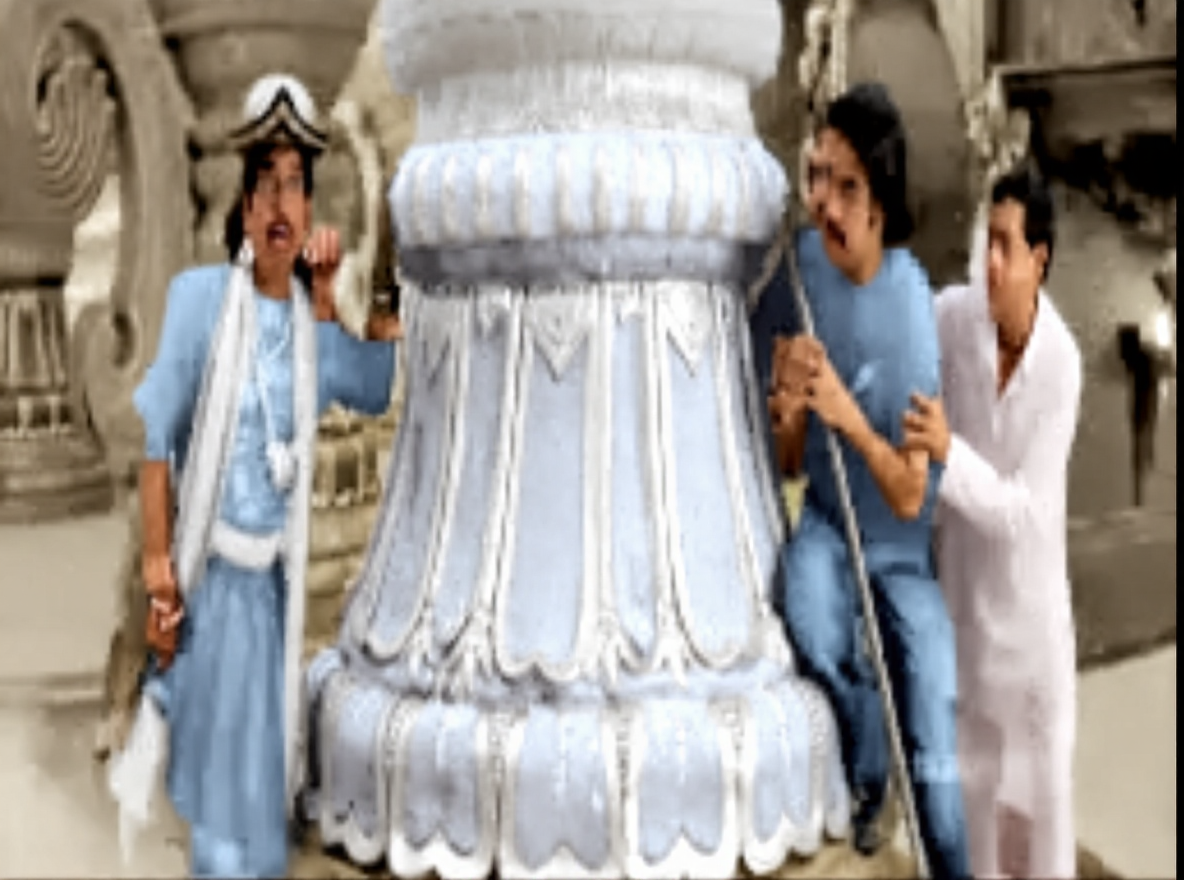

In [82]:
dynamic_input = "input/images/input_7 (1).png"
#prompt_text = "restore and colorize to pale skintones and  dont change the dress color"
#prompt_text_1 = "(pale porcelain skin tone:1.3), smooth skin texture, (restored and colorized:1.1), high quality photo, cinematic lighting"
#prompt_text_2= "restore and colorize skin with realistic pale tones, keep other areas unchanged "
#prompt_text_3= "colorize strictly only skin with realistic pale tones, keep other areas unchanged "
#prompt_text_4 = "(pale porcelain skin tone:1.3), smooth skin texture, (restored and colorized:1.1), high quality photo, cinematic lighting, finely detailed clothing"
#prompt_text_5= "(pale skin tones:1.4), (realistic skin texture:1.2), smooth skin, restored and colorized, high quality, sharp focus, cinematic lighting"
#prompt_text_6 = "(pale skin tones:1.4), (realistic skin texture:1.2), smooth skin, high quality, sharp focus, cinematic lighting"
#prompt_text_7 = "(pale skin tones:1.4), (realistic skin texture:1.2), smooth skin, restored and colorized, high quality, sharp focus, cinematic lighting, **(the dress is pure white:1.3), white fabric, high key white clothing**"
#prompt_text_8= "restore and colorize in white color"
#prompt_text_9 = "restore and colorize only skin , pale skintones and strictly to pure black or white dresses"
#prompt_text_10 = "colorise the dresses  in white color."
prompt_text_11 = "colorise the dresses strictly  in white color."
seed=2^24
flux_guidance = 5
results = run_workflow_with_image(dynamic_input, prompt_text = prompt_text_11, flux_guidance=flux_guidance, seed= seed, steps =20)
print("Saved outputs:")
for p in results:
    print(" -", p)

# Display first image inline (optional)

from IPython.display import display
display(Image.open(results[0]))

In [74]:
#prompt_text="restore and colorize this, light blue dresses only, no warm/cool tint in entire image, color background, natural skintones"
input_folder ="input/images"
#input_folder = "output/thathamanavadu"
output_folder = "output/results_background_22"
prompt_1= "restore and colorize this, no warm/cool tint in entire image, color background with natural, vivid colors,  natural and pale skintones"
#prompt_2 = "restore and colorize this, no warm/cool tint in entire image, color background, natural skintones, each person's dress differently (different color, natural, light, vivid)"
prompt_3 = "restore and colorize this, no warm/cool tint in entire image, color background with (many appropriate colors, natural, light, vivid) ,  natural and pale skintones"
prompt_4= "restore and colorize this with vivid colors, no warm/cool tint in entire image, color background with natural, vivid colors,  natural and pale skintones"
prompt_5 = "restore and colorize this, no warm/cool tint in entire image, color background with (different colors, natural, light, vivid) ,  natural and pale skintones"
prompt_6 = "restore and colorize this, no warm/cool tint in entire image, color background with modern colors (vivid colors, natural, light) ,  natural and pale skintones"
prompt_8 = "restore and colorize this, no warm/cool tint in entire image, high priority for coloring background with (different colors, natural, light, vivid)"
prompt_9 = "restore and colorize this, no warm/cool tint in entire image, color background with radiate colors,  natural and pale skintones"
prompt_10 ="restore and colorize this, no warm/cool tint in entire image, color background with cinematic vivid colors,  natural and pale skintones"
prompt_11 = "Restore and colorize this,  No warm/cool tint in entire image, color background, natural skintones"
prompt_12 = "Restore and colorize background with different colors, classic light vivid colors,  No warm/cool tint in entire image, natural skintones"
prompt_13 = "Restore and colorize background with many different colors and classic colors like cream, lime for indoor settings,  No warm/cool tint in entire image, natural skintones"
prompt_14_b = "Restore and colorize the image with a wide variety of classic indoor colors — include shades like cream, lime, beige, olive, sky blue, soft pink, lavender, mint green, terracotta, maroon, and ivory. Maintain a harmonious vintage indoor atmosphere with soft light reflections and balanced contrast. Avoid any strong warm or cool tint across the image. Ensure natural, realistic skin tones and subtle, elegant background hues."
prompt_17 = "Restore and colorize background with classic light colors like modern day interior house colors, walls light colors, furniture brown, ornaments gold,  No warm/cool tint in entire image, natural skintones"
prompt_18 = "Restore and colorize background with classic light colors like modern day interior house colors, walls light colors, furniture light brown, ornaments gold, stationary colorful, No warm/cool tint in entire image, natural skintones, no change in content of the image"
prompt_19 = "Restore and colorize background with classic light colors like modern day interior house colors, walls plain light colors not dominant colors, furniture light brown, ornaments gold, stationary colorful, No warm/cool tint in entire image, natural skintones, no change in content of the image"
prompt_20 = "restore and colorize this, no warm/cool tint in entire image, color background, natural and pale skintones, ornaments on people with gold color"
prompt_20 = "restore and colorize this, no warm/cool tint in entire image, color background, natural and pale skintones, ornaments on people with gold color, consistent dress colors across all 6 frames"
prompt_20 = "restore and colorize this, no warm/cool tint in entire image, color background, natural and pale skintones"
prompt_20 = "restore and colorize this, no warm/cool tint in entire image, color background, natural and pale skintones, ornaments on people with gold color"
prompt_21= "restore and colorize only skin , pale skintones and strictly to pure black dresses"
prompt_22= "restore and colorize only skin , pale skintones and strictly to pure black or white dresses"
process_folder(
    input_folder,
    output_folder,
    seed=2^24,
    steps=20,
    cfg=1.0,
    flux_guidance=5,
    prompt_text= prompt_21
)


Processing input_8 (1).png ...
Saved → output/results_background_22/input_8 (1).png (1280x720)
Processing input_ref_11.png ...
Saved → output/results_background_22/input_ref_11.png (1280x720)
Processing input_16 (1).png ...
Saved → output/results_background_22/input_16 (1).png (1920x1080)
Processing input_2 (1).png ...
Saved → output/results_background_22/input_2 (1).png (1280x720)
Processing input_15 (1).png ...
Saved → output/results_background_22/input_15 (1).png (1920x1080)
Processing input_17.png ...
Saved → output/results_background_22/input_17.png (1920x1080)
Processing input_11 (1).png ...
Saved → output/results_background_22/input_11 (1).png (1280x720)
Processing input_10 (1).png ...
Saved → output/results_background_22/input_10 (1).png (1280x720)
Processing input_3 (1).png ...
Saved → output/results_background_22/input_3 (1).png (1136x1066)
Processing input_4 (1).png ...
Saved → output/results_background_22/input_4 (1).png (1280x720)
Processing input_9 (1).png ...
Saved → out